# Cervical Spine Fracture Detection
This notebook aims at building a deep learning pipeline to detect fractures in CT-scans of the cervical spine spanning from C1 to C7, encompassing seven distinct categories. 
We will employ various python libraries such as matplotlib, numpy and Google's Tensorflow DL framework for this notebook as it also supports Keras.

**NOTE:** The dataset contains additional data such as bounding boxes which will be useful in building more robust models but we are not going to utilize that for this notebook. However, we will be using only images whose segmentations are available for our use.

### 1. Problem
To build an end-to-end multilabel image classifier which can identify the CT-scan images for cervical spine fractures in C1-C7 categories with respective probabilities.

### 2. Data
The data we're using is from Kaggle's RSNA 2k22 Cervical Spine Fracture Detection competition. For more information...  
https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/data

### 3. Evaluation
The evaluation metric for the predictions is binary weighted log loss function. It is the ratio of predictions our model got right and the total predictions made.

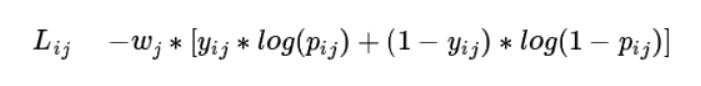

For more information...https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview

In [1]:
#During submission internet is disabled. Hence install this package manually
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [2]:
!apt-get install -y graphviz libgraphviz-dev libcgraph6

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libcgraph6 is already the newest version (2.42.2-6).
libcgraph6 set to manually installed.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-2 librsvg2-common libxdot4
Suggested packages:
  gvfs librsvg2-bin
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
The following packages will be upgraded:
  librsvg2-2
1 upgraded, 9 newly installed, 0 to remove and 73 not upgraded.
Need to get 5406 kB of archives.
After this operation, 7363 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu

In [3]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-660elv1l
  Running command git clone --filter=blob:none --quiet https://github.com/danielegrattarola/spektral /tmp/pip-req-build-660elv1l
  Resolved https://github.com/danielegrattarola/spektral to commit a5fa5e38fca4eaca1e47ccfe1b00e0a61f64648b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spektral: filename=spektral-1.3.1-py3-none-any.whl size=140121 sha256=a87e5fe2cb4a167f6df2210ba316eee6350476b95bc96c36b5043fd64caf395c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_lx6k92/wheels/02/e2/81/95bc0d8fb087de2ca12e892947cd5bfc3ec1046599312faf16
Successfully built spektral


In [4]:
import pandas as pd
import numpy as np
import pydicom as dicom
import glob
import nibabel as nib
import os
import re
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, DenseNet121, InceptionResNetV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Import libraries and load datasets

In [5]:
base_dir = r'/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
train_images = os.path.join(base_dir,'train_images')
test_images = os.path.join(base_dir,'test_images')
train_df = pd.read_csv(os.path.join(base_dir,'train.csv'))
segmentation_meta_data = pd.read_csv(r'/kaggle/input/rsna-cervical-fracture-segmentation-metadata/meta_segmentation.csv')

In [6]:
segmentation_meta_data

,Rows,Columns,SOPInstanceUID,ContentDate,SliceThickness,InstanceNumber,ImagePositionPatientX,ImagePositionPatientY,ImagePositionPatientZ,PhotometricInterpretation,PixelSpacingX,PixelSpacingY,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,Slice,SliceRatio
0,512,512,1.2.826.0.1.3680043.1363.1.12,20220727,1.000,12,-149.208008,-350.208008,65.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,11.0,0.055556
1,512,512,1.2.826.0.1.3680043.1363.1.120,20220727,1.000,120,-149.208008,-350.208008,173.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,1,1,0,119.0,0.601010
2,512,512,1.2.826.0.1.3680043.1363.1.141,20220727,1.000,141,-149.208008,-350.208008,194.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,1,1,140.0,0.707071
3,512,512,1.2.826.0.1.3680043.1363.1.18,20220727,1.000,18,-149.208008,-350.208008,71.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,17.0,0.085859
4,512,512,1.2.826.0.1.3680043.1363.1.9,20220727,1.000,9,-149.208008,-350.208008,62.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,8.0,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,512,512,1.2.826.0.1.3680043.26990.1.26,20220727,0.625,26,-84.500000,-61.100000,-14.060,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,25.0,0.103734
29828,512,512,1.2.826.0.1.3680043.26990.1.185,20220727,0.625,185,-84.500000,-61.100000,-113.435,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,1,1,184.0,0.763485
29829,512,512,1.2.826.0.1.3680043.26990.1.221,20220727,0.625,221,-84.500000,-61.100000,-135.935,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,220.0,0.912863
29830,512,512,1.2.826.0.1.3680043.26990.1.13,20220727,0.625,13,-84.500000,-61.100000,-5.935,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,12.0,0.049793


In [7]:
segmentation_meta_data['PhotometricInterpretation'].value_counts()

PhotometricInterpretation
MONOCHROME2    29832
Name: count, dtype: int64

In [8]:
segmentation_meta_data.shape

(29832, 26)

In [9]:
segmentation_meta_data.columns

Index(['Rows', 'Columns', 'SOPInstanceUID', 'ContentDate', 'SliceThickness',
       'InstanceNumber', 'ImagePositionPatientX', 'ImagePositionPatientY',
       'ImagePositionPatientZ', 'PhotometricInterpretation', 'PixelSpacingX',
       'PixelSpacingY', 'WindowCenter', 'WindowWidth', 'RescaleIntercept',
       'RescaleSlope', 'StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'Slice', 'SliceRatio'],
      dtype='object')

## 2. Data Processing
In this notebook, we'll include only those images whose segmentations are available and will process them for modelling.

In [10]:
columns = ['StudyInstanceUID','SOPInstanceUID','C1','C2','C3','C4','C5','C6','C7']
seg_labels = segmentation_meta_data[columns]
seg_labels.head(2)

,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0


In [11]:
#Get Slice instance number
seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1])
seg_labels

/tmp/ipykernel_32/1938975322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1])


,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7,slice
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0,12
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0,120
2,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.141,0,0,0,0,0,1,1,141
3,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.18,0,0,0,0,0,0,0,18
4,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.9,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...
29827,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.26,0,0,0,0,0,0,0,26
29828,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.185,0,0,0,0,0,1,1,185
29829,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.221,0,0,0,0,0,0,0,221
29830,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.13,0,0,0,0,0,0,0,13


### 2.1 Custom utility functions
We'll write some utility functions to assist us in loading and generating batches of images and labels. Further also some additions to visualize the final scores on the test data.

In [12]:
# Function to load DICOM images
def load_scan(dcm_paths):  
    patient_scan = [dicom.dcmread(paths) for paths in dcm_paths]
    return patient_scan

def get_pixels_hu(img):
    image = cv2.resize(img.pixel_array,(128, 128),interpolation = cv2.INTER_NEAREST)
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0, the intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    # Convert to Hounsfield units (HU)    
    intercept = np.array(img.RescaleIntercept)
    slope = np.array(img.RescaleSlope)
    image= (slope * image.astype("float64")) + intercept
#     plt.imshow(image.astype("int16"), cmap='bone') 
    return image.astype("int16")

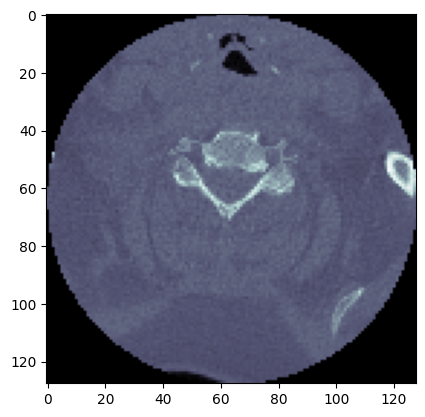

In [13]:
path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
study_instances = list(seg_labels['StudyInstanceUID'].unique())
patient_slices = []
org_images = []
for study_instance in study_instances:
    slices = list(seg_labels[seg_labels['StudyInstanceUID']==study_instance]['slice'])
    dcm_paths = [path+'/'+study_instance+'/'+slice+'.dcm' for slice in slices]
    image = load_scan(dcm_paths)
    org_images.append(image)
    slices = [dicom.read_file(dcm_path) for dcm_path in dcm_paths]
    patient_slice = [get_pixels_hu(slice) for slice in slices]
    patient_slices.append(patient_slice)

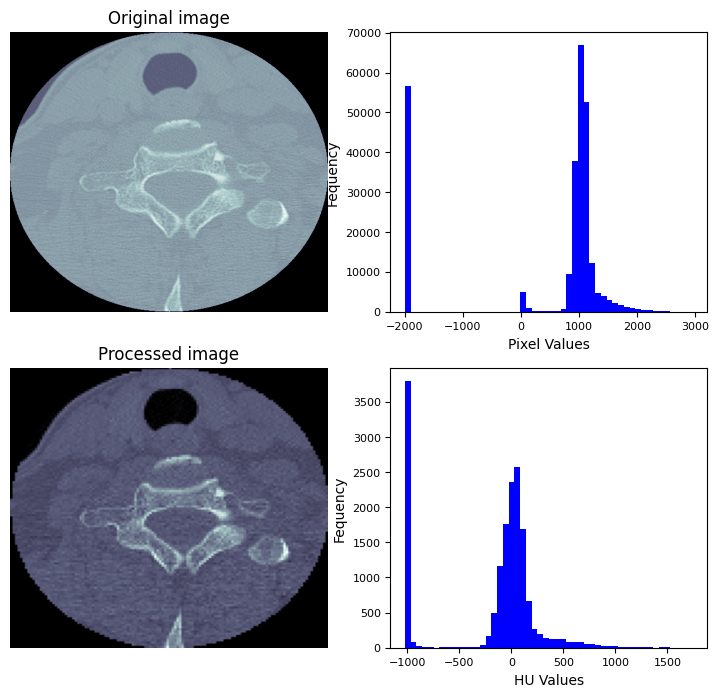

In [37]:
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

start = 10
img = 20
plt.figure(figsize=(9, 8))
# Ploting pixel array
plt.subplot(2, 2, 1)
plt.imshow(org_images[start][img].pixel_array,cmap='bone', aspect='auto')
plt.title('Original image')
plt.axis("off")

# Ploting pixel array distribution
plt.subplot(2, 2, 2)
plt.hist(org_images[start][img].pixel_array.flatten(),color="b",bins=50)
# plt.title('Pixel array distribution')
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")

#Ploting HU array
plt.subplot(2, 2, 3)
plt.imshow(get_pixels_hu(org_images[start][img]),cmap='bone', aspect='auto')
plt.title('Processed image')
plt.axis("off")

# Ploting HU distribution
plt.subplot(2, 2, 4)
plt.hist(patient_slices[start][img].flatten(),color="b",bins=50)
# plt.title('HU distribution')
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.show()

In [13]:
def load_dicom(path):
    '''
    Function to load and transform DICOM images.
    
    Parameters:
    path(string): Path to the DICOM images

    Returns:
    Transformed and resized image.
    
    '''
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
#     data=img.pixel_array
    data=get_pixels_hu(img)
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(128, 128), cv2.COLOR_GRAY2RGB)

def ImgDataGenerator(train_df,base_path):
    '''
    Function to read dicom image path and store the images as numpy arrays.

    Parameters:
    train_df: Pandas dataframe.
    base_path: Python list containing image filepaths.

    Returns:
    [Train image dataset, Train image labels]

    '''
    trainset = []
    trainlabel = []
    for i in tqdm(range(len(train_df))):
        study_id = train_df.loc[i,'StudyInstanceUID']
        slice_id = train_df.loc[i,'slice']+'.dcm'
        study_path = study_id+'/'+slice_id

        path = os.path.join(base_path, study_path)

        img = load_dicom(path)
        img = cv2.resize(img, (128 , 128))
        image = img_to_array(img)
        image = image / 255.0
        trainset += [image]
        cur_label = [train_df.loc[i,f'C{j}'] for j in range(1,8)]
        trainlabel += [cur_label]

    return np.array(trainset), np.array(trainlabel)
    
def metrics(y_test, y_pred_binary):
    '''
    Function to display accuracy, precision, recall and f1-score for the classification task.
    
    Parameters:
    y_test: True labels.
    y_pred_binary: Predicted binary labels.

    Returns:
    Pandas dataframe containing class-wise Sensitivity, Specificity, and F1-score.
    
    '''
    classes = np.array(seg_labels.columns[2:-1])
    df_res = []
    precision_per_class = precision_score(y_test, y_pred_binary, average=None)
    recall_per_class = recall_score(y_test, y_pred_binary, average=None)
    f1_per_class = f1_score(y_test, y_pred_binary, average=None)

    for i in range(len(classes)):
        df_res.append([classes[i], recall_per_class[i], precision_per_class[i], f1_per_class[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Sensitivity','Specificity', 'F1-score'])
    return df_res

def plot_history(history):
    '''
    Function to plot the train and validation accuracy and loss.
    
    Parameters:
    history: model train history

    Returns:
    None.
    
    '''
    hist = history.history
    plt.figure(figsize=(8, 4));
    plt.suptitle(f"Performance Metrics", fontsize=12)

    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve', fontsize=8)
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['binary_accuracy'], label='train')
    plt.plot(hist['val_binary_accuracy'], label='validation')
    plt.title('Train and val accuracy curve', fontsize=8)
    plt.legend();
    
def callback(model_name, patience=5): 
    '''
    Function to define callback for model training.
    
    Parameters:
    model_name(string): Name for the saved model with `.h5` extension.
    patience: Patience for early stopping. Usually, the value lies between 5-11.

    Returns:
    [Early Stopping Callback, Model Checkpoint Callback]
    
    '''
    early_stopping = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint(model_name, save_best_only=True)
    learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                        patience=2, 
                                                        verbose=1, 
                                                        factor=0.5, 
                                                        min_lr=0.00001)
    return [early_stopping, model_checkpoint, learning_rate_reduction]

In [14]:
# Convert train images of segmented studyids to array
X_seg, y_seg = ImgDataGenerator(seg_labels,train_images)
X_seg.shape,y_seg.shape

100%|██████████| 29832/29832 [10:30<00:00, 47.31it/s]


((29832, 128, 128, 3), (29832, 7))

In [ ]:
# save for future use
# np.save('/kaggle/working/seg_train_images.npy',X_seg)
# np.save('/kaggle/working/seg_train_images_labels.npy',y_seg)

# #Uncomment this if you want to use the above output in the next run
# #X_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images.npy')
# #y_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images_labels.npy')

In [ ]:
# # Visualize a random CT scan image
# plt.imshow(X_seg[500], cmap = 'bone')
# plt.title(y_seg[500]) # The above slice represents cervicals C3 and C4

In [15]:
# Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X_seg, y_seg, random_state=42, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26848, 128, 128, 3), (26848, 7), (2984, 128, 128, 3), (2984, 7))

In [16]:
# Prepare data batches for training images
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)
# Prepare data batches for validation images
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)

## 3. Modelling
We'll opt for three different modelling approaches:
1. **Custom CNN** - Here we will implement our own custom CNN model from scratch involving blocks of Convolution, Pooling and DropOut layers.
2. **Transfer Learning models** - In this section, we will employ various pre-trained deep learning models to further improve on the results of the Custom CNN model.
3. **Encoder decoder Architecture** - Finally, we will implement an encoder-decoder model where we will use the U-Net model for encoder and the best performing transfer learning model as a decoder. 

In [17]:
def conv_block(input, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    # Input layer
    inputs = layers.Input(input_shape)
    
    # Pre-trained transfer learning model
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
#     encoder.trainable = False
    # Encoder
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)
    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = layers.ZeroPadding2D(((1, 0), (1, 0)))(s2)         ## (256 x 256)
    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = layers.ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)
    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = layers.ZeroPadding2D(((2, 1), (2, 1)))(s4)           ## (64 x 64)

    # Bridge
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = layers.ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    # Decoder layer
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    # Output layer
    gap = layers.GlobalAveragePooling2D()(d4)
    dropout = layers.Dropout(0.2)(gap)
    outputs = layers.Dense(7, activation="sigmoid")(dropout)
    # Build the model
    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    
    return encoder, model

inception_resnet, model = build_inception_resnetv2_unet(input_shape = (128, 128, 3))

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# inception_resnet.summary() #none:3, 3:13, 74:266, 161:606
for i in range(len(inception_resnet.layers)):
    print (i, inception_resnet.layers[i].name)

In [ ]:
plot_model(inception_resnet, to_file='model_plot_inception_resnet.png', show_shapes=True, show_layer_names=True)

In [18]:
model_0 = model

In [ ]:
plot_model(model_0, to_file='model_plot_inception_resnet_unet.png', show_shapes=True, show_layer_names=True)

In [ ]:
for i in range(len(model_0.layers)):
    print (i, model_0.layers[i].name)
    
for layer in model_0.layers[274:]:
    layer.trainable=True
for layer in model_0.layers[0:274]:
    layer.trainable=False

In [19]:
model_0.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                             

In [20]:
# Compile the model
model_0.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
history_model_0 = model_0.fit(train_dataset, 
                              epochs=100, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=15, model_name="model_0_InceptionResNetV2.h5")])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
52/52 [==============================] - 41s 427ms/step - loss: 0.5436 - binary_accuracy: 0.7639 - val_loss: 0.5931 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 2/100
52/52 [==============================] - 17s 338ms/step - loss: 0.4234 - binary_accuracy: 0.8408 - val_loss: 0.5489 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 3/100
52/52 [==============================] - 17s 338ms/step - loss: 0.3889 - binary_accuracy: 0.8489 - val_loss: 0.5269 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 4/100
52/52 [==============================] - 17s 338ms/step - loss: 0.3683 - binary_accuracy: 0.8477 - val_loss: 0.4582 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 5/100
52/52 [==============================] - 17s 337ms/step - loss: 0.3479 - binary_accuracy: 0.8491 - val_loss: 0.4359 - val_binary_accuracy: 0.8373 - lr: 0.0100
Epoch 6/100
52/52 [==============================] - 17s 338ms/step - loss: 0.3278 - binary_accuracy: 0.8568 - val_loss: 0.3483 - val_binary_accu

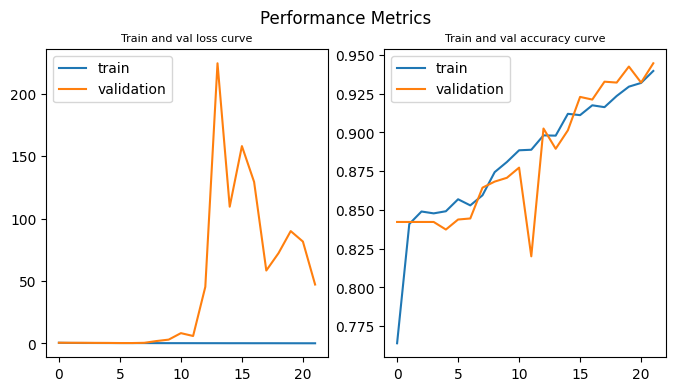

In [21]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_0)

In [22]:
# Get the class-wise scores on the test data
y_pred_0 = model_0.predict(X_test)
threshold = 0.4
y_pred_binary_0 = (y_pred_0 > threshold).astype(int)
score_0 = model_0.evaluate(X_test, y_test, verbose = 1)
df_met_model_0 = metrics(y_test, y_pred_binary_0)
print(f'Test loss:{score_0[0]}\n Test accuracy:{score_0[1]}')
df_met_model_0

94/94 [==============================] - 7s 72ms/step - loss: 0.3381 - binary_accuracy: 0.8444
Test loss:0.33814921975135803
 Test accuracy:0.8444082736968994


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Sensitivity,Specificity,F1-score
0,C1,0.000000,0.000000,0.000000
1,C2,0.903963,0.466562,0.615464
2,C3,0.000000,0.000000,0.000000
3,C4,0.000000,0.000000,0.000000
4,C5,0.000000,0.000000,0.000000
5,C6,0.000000,0.000000,0.000000
6,C7,0.374745,0.821429,0.514685


#### Predictions on the test data

In [23]:
img = X_test[17]
proba = model_0.predict(img.reshape(1,128,128,3))
# Fetches the probability value for each class in a sorted order
np.argsort(proba[0])

1/1 [==============================] - 1s 639ms/step


array([2, 3, 0, 1, 4, 5, 6])

### 3.3. Transfer learning models
#### 3.3.1 DenseNet121

In [38]:
base_model_2 = DenseNet121(include_top=False, input_shape=(128, 128, 3))
model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(layers.GlobalAveragePooling2D())
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_2.summary()

# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 7,044,679
Trainable params: 6,961,031
Non-trainable params: 83,648
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
# Train the model
history_model_2 = model_2.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_2_denseNet121.h5")])

Epoch 1/50
52/52 [==============================] - 19s 176ms/step - loss: 0.3591 - binary_accuracy: 0.8492 - val_loss: 0.3453 - val_binary_accuracy: 0.8453 - lr: 0.0100
Epoch 2/50
52/52 [==============================] - 7s 136ms/step - loss: 0.2392 - binary_accuracy: 0.9028 - val_loss: 0.2481 - val_binary_accuracy: 0.8919 - lr: 0.0100
Epoch 3/50
52/52 [==============================] - 7s 134ms/step - loss: 0.2053 - binary_accuracy: 0.9141 - val_loss: 0.2253 - val_binary_accuracy: 0.9041 - lr: 0.0100
Epoch 4/50
52/52 [==============================] - 7s 137ms/step - loss: 0.1865 - binary_accuracy: 0.9226 - val_loss: 0.2069 - val_binary_accuracy: 0.9109 - lr: 0.0100
Epoch 5/50
52/52 [==============================] - 8s 149ms/step - loss: 0.1671 - binary_accuracy: 0.9332 - val_loss: 0.1690 - val_binary_accuracy: 0.9286 - lr: 0.0100
Epoch 6/50
52/52 [==============================] - 7s 136ms/step - loss: 0.1602 - binary_accuracy: 0.9358 - val_loss: 0.1508 - val_binary_accuracy: 0.934

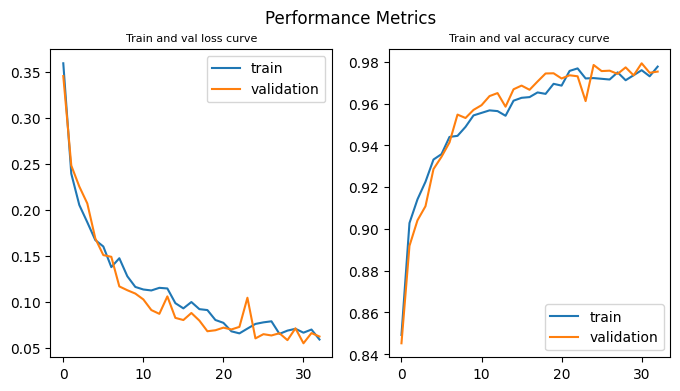

In [40]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_2)

In [41]:
# Get the class-wise scores on the test data
y_pred_2 = model_2.predict(X_test)
threshold = 0.4
y_pred_binary_2 = (y_pred_2 > threshold).astype(int)
score_2 = model_2.evaluate(X_test, y_test, verbose = 1)
df_met_model_2 = metrics(y_test, y_pred_binary_2)
print(f'Test loss:{score_2[0]}\n Test accuracy:{score_2[1]}')
df_met_model_2

94/94 [==============================] - 3s 29ms/step - loss: 0.0624 - binary_accuracy: 0.9753
Test loss:0.06243549659848213
 Test accuracy:0.9752967953681946


,Class,Sensitivity,Specificity,F1-score
0,C1,0.920000,0.955844,0.937580
1,C2,0.905488,0.969005,0.936170
2,C3,0.964200,0.889868,0.925544
3,C4,0.978673,0.745487,0.846311
4,C5,0.935268,0.914847,0.924945
5,C6,0.900217,0.958430,0.928412
6,C7,0.959267,0.973140,0.966154


#### 3.3.2 InceptionV3

In [42]:
base_model_3 = InceptionV3(include_top=False, input_shape=(128, 128, 3))
model_3 = Sequential()
model_3.add(base_model_3)
model_3.add(layers.GlobalAveragePooling2D())
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_3.summary()

# Compile the model
model_3.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 21,817,127
Trainable params: 21,782,695
Non-trainable params: 34,432
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
# Train the model
history_model_3 = model_3.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_3_inceptionV3.h5")])

Epoch 1/50
52/52 [==============================] - 15s 154ms/step - loss: 0.3891 - binary_accuracy: 0.8321 - val_loss: 0.7109 - val_binary_accuracy: 0.8449 - lr: 0.0100
Epoch 2/50
52/52 [==============================] - 7s 127ms/step - loss: 0.2726 - binary_accuracy: 0.8800 - val_loss: 0.4470 - val_binary_accuracy: 0.8807 - lr: 0.0100
Epoch 3/50
52/52 [==============================] - 6s 124ms/step - loss: 0.2375 - binary_accuracy: 0.8965 - val_loss: 0.3496 - val_binary_accuracy: 0.8867 - lr: 0.0100
Epoch 4/50
52/52 [==============================] - 6s 122ms/step - loss: 0.2212 - binary_accuracy: 0.9057 - val_loss: 0.2325 - val_binary_accuracy: 0.9063 - lr: 0.0100
Epoch 5/50
52/52 [==============================] - 6s 124ms/step - loss: 0.2021 - binary_accuracy: 0.9148 - val_loss: 0.2130 - val_binary_accuracy: 0.9099 - lr: 0.0100
Epoch 6/50
52/52 [==============================] - 6s 126ms/step - loss: 0.1835 - binary_accuracy: 0.9208 - val_loss: 0.1717 - val_binary_accuracy: 0.930

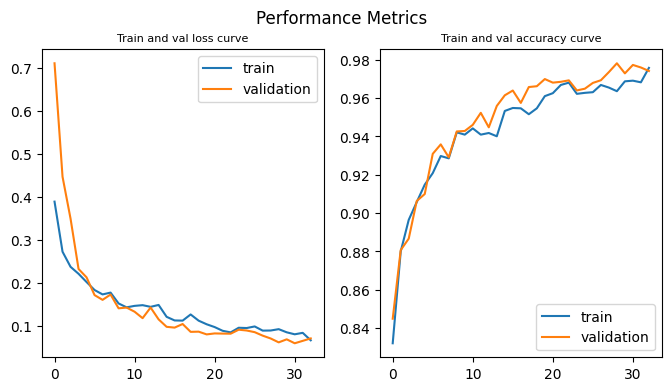

In [44]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_3)

In [45]:
# Get the class-wise scores on the test data
y_pred_3 = model_3.predict(X_test)
threshold = 0.4
y_pred_binary_3 = (y_pred_3 > threshold).astype(int)
score_3 = model_3.evaluate(X_test, y_test, verbose = 1)
df_met_model_3 = metrics(y_test, y_pred_binary_3)
print(f'Test loss:{score_3[0]}\n Test accuracy:{score_3[1]}')
df_met_model_3

94/94 [==============================] - 2s 23ms/step - loss: 0.0710 - binary_accuracy: 0.9741
Test loss:0.0709512010216713
 Test accuracy:0.9741478562355042


,Class,Sensitivity,Specificity,F1-score
0,C1,0.910000,0.950392,0.929757
1,C2,0.931402,0.968304,0.949495
2,C3,0.954654,0.886918,0.919540
3,C4,0.971564,0.779468,0.864979
4,C5,0.941964,0.895966,0.918390
5,C6,0.780911,0.983607,0.870617
6,C7,0.940937,0.942857,0.941896


#### 3.3.3 InceptionResNetV2

In [32]:
base_model_4 = InceptionResNetV2(include_top=False, input_shape=(128, 128, 3))
model_4 = Sequential()
model_4.add(base_model_4)
model_4.add(layers.GlobalAveragePooling2D())
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_4.summary()

# Compile the model
model_4.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 10759     
                                                                 
Total params: 54,347,495
Trainable params: 54,286,951
Non-trainable params: 60,544
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
# Train the model
history_model_4 = model_4.fit(train_dataset, 
                              epochs=100, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_4_InceptionResNetV2.h5")])

Epoch 1/100
52/52 [==============================] - 35s 341ms/step - loss: 0.3731 - binary_accuracy: 0.8341 - val_loss: 0.4765 - val_binary_accuracy: 0.8457 - lr: 0.0100
Epoch 2/100
52/52 [==============================] - 14s 274ms/step - loss: 0.2560 - binary_accuracy: 0.8868 - val_loss: 0.3942 - val_binary_accuracy: 0.8512 - lr: 0.0100
Epoch 3/100
52/52 [==============================] - 15s 285ms/step - loss: 0.2151 - binary_accuracy: 0.9073 - val_loss: 0.2868 - val_binary_accuracy: 0.8736 - lr: 0.0100
Epoch 4/100
52/52 [==============================] - 14s 276ms/step - loss: 0.2032 - binary_accuracy: 0.9157 - val_loss: 0.2289 - val_binary_accuracy: 0.9043 - lr: 0.0100
Epoch 5/100
52/52 [==============================] - 14s 274ms/step - loss: 0.1744 - binary_accuracy: 0.9274 - val_loss: 0.2158 - val_binary_accuracy: 0.9020 - lr: 0.0100
Epoch 6/100
52/52 [==============================] - 14s 275ms/step - loss: 0.1548 - binary_accuracy: 0.9327 - val_loss: 0.1603 - val_binary_accu

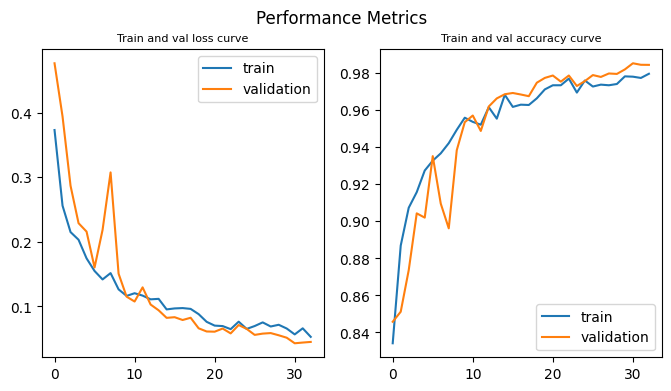

In [34]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_4)

In [35]:
# Get the class-wise scores on the test data
y_pred_4 = model_4.predict(X_test)
threshold = 0.4
y_pred_binary_4 = (y_pred_4 > threshold).astype(int)
score_4 = model_4.evaluate(X_test, y_test, verbose = 1)
df_met_model_4 = metrics(y_test, y_pred_binary_4)
print(f'Test loss:{score_4[0]}\n Test accuracy:{score_4[1]}')
df_met_model_4

94/94 [==============================] - 4s 47ms/step - loss: 0.0450 - binary_accuracy: 0.9844
Test loss:0.044960081577301025
 Test accuracy:0.9843929409980774


,Class,Sensitivity,Specificity,F1-score
0,C1,0.940000,0.951899,0.945912
1,C2,0.955793,0.976636,0.966102
2,C3,0.964200,0.930876,0.947245
3,C4,0.966825,0.906667,0.935780
4,C5,0.919643,0.962617,0.940639
5,C6,0.934924,0.988532,0.960981
6,C7,0.973523,0.940945,0.956957


## 4. Predictions on test data 
So far, model_2 i.e., DenseNet121 has shown the best performance, hence, we'll make predictions on it.

In [36]:
img = X_test[17]
proba = model_2.predict(img.reshape(1,128,128,3))
# Fetches the probability value for each class in a sorted order
np.argsort(proba[0])

1/1 [==============================] - 1s 790ms/step


array([3, 4, 2, 0, 1, 5, 6])

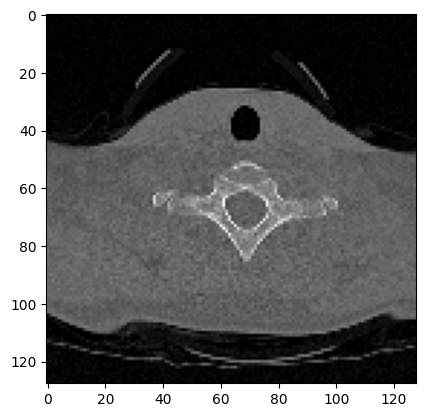

In [37]:
plt.imshow(img)